<a href="https://colab.research.google.com/github/den1shh/summer-school-qml/blob/main/qnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a binary classificator using quantum layers

Required installations and imports:

In [2]:
!pip install pennylane qiskit pennylane-qiskit ply mitiq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.6/171.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 63.4 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import mitiq
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

Fixation of random seed:

In [4]:
np.random.seed(42)
torch.manual_seed(42)

Setting general hyperparameters:

In [5]:
input_dim = 16 #dimension of input vector
num_qubits = 4 #number of qubits used in quantum layer. equals to the dimension of classical layer outcome

learning_rate = 0.1
epochs = 100
qdi_depth = 1


Setting hyperparameters for QDI. The meaning of these parameters is illustrated by the following picture: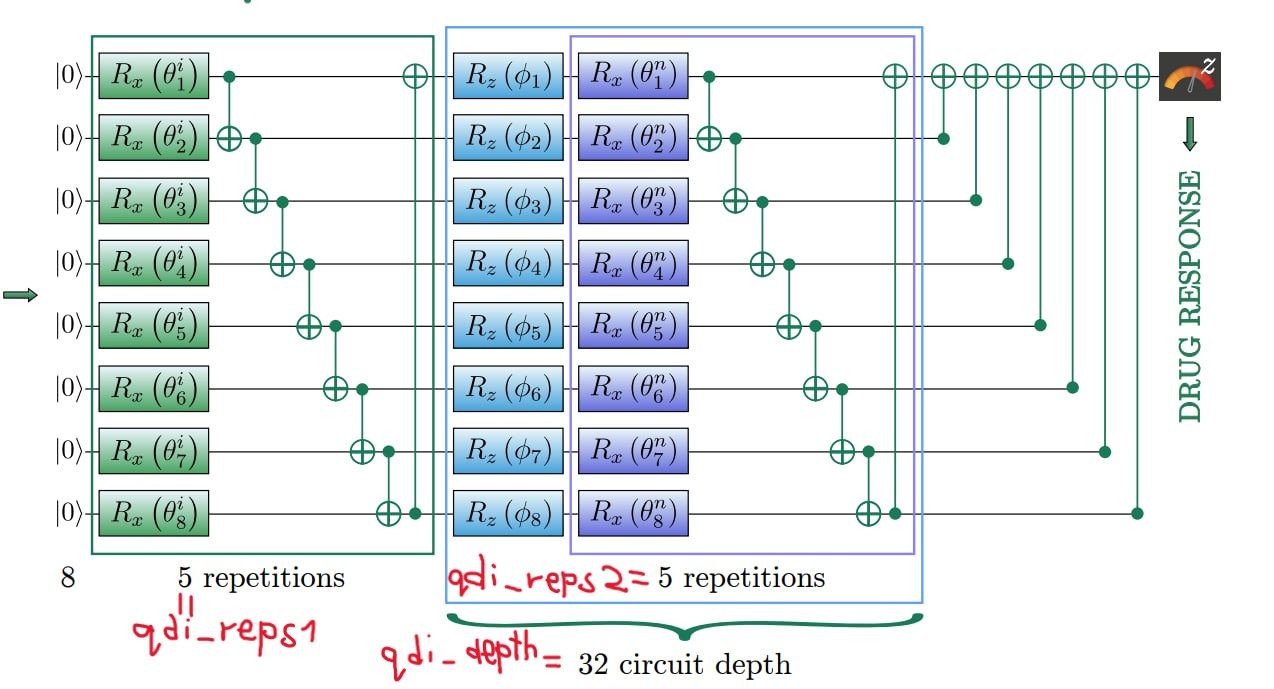

In [6]:
qdi_reps1 = 3
qdi_reps2 = 3
qdi_depth = 3

Setting hyperparameters for EFQ:

In [7]:
efq_depth = 2 #depth of efq layer

Setting hyperparameters for PQN:

In [8]:
pqn_c = 2 #number of circuits which are executed in parallel. num_qubits % pqn_c must be equal to zero!!
par_qubits = num_qubits//pqn_c
if num_qubits % pqn_c != 0:
    print("num_qubits % pqn_c must be equal to zero!! following computations will cause an error")

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
# [ds] = qml.data.load("other", name="bars-and-stripes")

# train_features = (np.sign(np.array(ds.train['4']['inputs']))+1)/2
# train_labels =(np.array(ds.train['4']['labels']) + 1) / 2
# test_features = (np.sign(np.array(ds.test['4']['inputs']))+1)/2
# test_labels =(np.array(ds.test['4']['labels']) + 1) / 2

 a simplified version of the MNIST handwritten digits dataset. This version involves distinguishing between digits 3 and 5 rather than the full range 0-9.

In [11]:
# [ds] = qml.data.load("other", name="mnist-pca")

# train_features = np.array(ds.train['16']['inputs'])
# train_labels =(np.array(ds.train['16']['labels']) + 1) / 2
# test_features = np.array(ds.test['16']['inputs'])
# test_labels =(np.array(ds.test['16']['labels']) + 1) / 2

In [12]:
[ds] = qml.data.load("other", name="linearly-separable")

train_features = np.array(ds.train['16']['inputs'])
train_labels =(np.array(ds.train['16']['labels']) + 1) / 2
test_features = np.array(ds.test['16']['inputs'])
test_labels =(np.array(ds.test['16']['labels']) + 1) / 2

In [13]:
class BaSDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.X = torch.tensor(data_x).float()
        self.y = torch.tensor(data_y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]


In [14]:
train_dataset = BaSDataset(train_features, train_labels)
test_dataset = BaSDataset(test_features, test_labels)

In [15]:
batch_size = 60
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Noiseless simulator

In [16]:
dev = qml.device("lightning.qubit", wires=range(num_qubits))

In [17]:
# @title QDI layer
@qml.qnode(dev, interface='torch', diff_method="adjoint")
def qdi_circuit(weights, input_array, wires=range(num_qubits)):
    for r in range(qdi_reps1):
        for i in range(len(wires)):
            qml.RX(weights[r][i], wires=wires[i])
        for j in range(len(wires)-1):
            qml.CNOT(wires=[wires[j], wires[j+1]])
        qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
        qml.Barrier()
    for d in range(qdi_depth):
        qml.AngleEmbedding(input_array, wires=range(num_qubits), rotation='Z')
        for r in range(qdi_reps2):
            for i in range(len(wires)):
                qml.RX(weights[qdi_reps1+d*r][i], wires=wires[i])
            for j in range(len(wires)-1):
                qml.CNOT(wires=[wires[j], wires[j+1]])
            qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
            qml.Barrier()
        qml.Barrier()
    return qml.expval(qml.PauliY(0))



In [18]:
print(qml.draw(qdi_circuit)(np.ones((qdi_reps1 + qdi_depth*qdi_reps2, num_qubits)), np.ones(num_qubits)))

0: ──RX(1.00)─╭●───────╭X──||──RX(1.00)─╭●───────╭X──||──RX(1.00)─╭●───────╭X──||
1: ──RX(1.00)─╰X─╭●────│───||──RX(1.00)─╰X─╭●────│───||──RX(1.00)─╰X─╭●────│───||
2: ──RX(1.00)────╰X─╭●─│───||──RX(1.00)────╰X─╭●─│───||──RX(1.00)────╰X─╭●─│───||
3: ──RX(1.00)───────╰X─╰●──||──RX(1.00)───────╰X─╰●──||──RX(1.00)───────╰X─╰●──||

──╭AngleEmbedding(M0)──RX(1.00)─╭●───────╭X──||──RX(1.00)─╭●───────╭X──||──RX(1.00)─╭●───────╭X──||
──├AngleEmbedding(M0)──RX(1.00)─╰X─╭●────│───||──RX(1.00)─╰X─╭●────│───||──RX(1.00)─╰X─╭●────│───||
──├AngleEmbedding(M0)──RX(1.00)────╰X─╭●─│───||──RX(1.00)────╰X─╭●─│───||──RX(1.00)────╰X─╭●─│───||
──╰AngleEmbedding(M0)──RX(1.00)───────╰X─╰●──||──RX(1.00)───────╰X─╰●──||──RX(1.00)───────╰X─╰●──||

───||─╭AngleEmbedding(M0)──RX(1.00)─╭●───────╭X──||──RX(1.00)─╭●───────╭X──||──RX(1.00)─╭●───────╭X
───||─├AngleEmbedding(M0)──RX(1.00)─╰X─╭●────│───||──RX(1.00)─╰X─╭●────│───||──RX(1.00)─╰X─╭●────│─
───||─├AngleEmbedding(M0)──RX(1.00)────╰X─╭●─│───||──RX(1.00)────╰X─╭●

In [19]:
# @title EFQ layer
def efq_subroutine(params, input_array):
    wires = range(num_qubits)
    j = 0
    for i in range(len(wires)):
        qml.RY(params[i+j], wires=i)
        qml.RZ(params[i+j+1], wires=i)
        qml.RX(params[i+j+2], wires=i)
        j += 2

    for i in range(len(wires)):
        qml.CNOT(wires=[i, (i + 1) % len(wires)])

    j = 0
    for i in range(len(wires)):
        qml.RY(params[3*len(wires)+i+j], wires=i)
        qml.RZ(params[3*len(wires)+i+j+1], wires=i)
        qml.RX(params[3*len(wires)+i+j+2], wires=i)
        j += 2
    qml.Barrier()
    for i in range(len(wires)):
        qml.AngleEmbedding(2**i*input_array[i].reshape((1,)), wires=[i], rotation='Z')
    j = 0
    qml.Barrier()
    for i in range(len(wires)):
        qml.RY(params[6*len(wires)+i+j], wires=i)
        qml.RZ(params[6*len(wires)+i+j+1], wires=i)
        qml.RX(params[6*len(wires)+i+j+2], wires=i)
        j += 2

    for i in range(len(wires)):
        qml.CNOT(wires=[i, (i + 1) % len(wires)])

    j = 0
    for i in range(len(wires)):
        qml.RY(params[9*len(wires)+i+j], wires=i)
        qml.RZ(params[9*len(wires)+i+j+1], wires=i)
        qml.RX(params[9*len(wires)+i+j+2], wires=i)
        j += 2
    qml.Barrier()
    for i in range(len(wires)-1, 0, -1):
        qml.CNOT(wires=[i, 0])

@qml.qnode(dev, interface="torch", diff_method="adjoint")
def efq_circuit(weights, input_array):
    qml.layer(efq_subroutine, efq_depth, params = weights, input_array = input_array)
    return qml.expval(qml.PauliZ(0))


In [20]:
print(qml.draw(efq_circuit)(torch.ones((12*efq_depth*num_qubits,)), torch.ones(num_qubits)))

0: ──RY(1.00)──RZ(1.00)──RX(1.00)─╭●───────╭X──RY(1.00)──RZ(1.00)──RX(1.00)──||──AngleEmbedding(M0)
1: ──RY(1.00)──RZ(1.00)──RX(1.00)─╰X─╭●────│───RY(1.00)──RZ(1.00)──RX(1.00)──||──AngleEmbedding(M1)
2: ──RY(1.00)──RZ(1.00)──RX(1.00)────╰X─╭●─│───RY(1.00)──RZ(1.00)──RX(1.00)──||──AngleEmbedding(M2)
3: ──RY(1.00)──RZ(1.00)──RX(1.00)───────╰X─╰●──RY(1.00)──RZ(1.00)──RX(1.00)──||──AngleEmbedding(M3)

───||──RY(1.00)──RZ(1.00)──RX(1.00)─╭●───────╭X──RY(1.00)──RZ(1.00)──RX(1.00)──||─╭X─╭X───────
───||──RY(1.00)──RZ(1.00)──RX(1.00)─╰X─╭●────│───RY(1.00)──RZ(1.00)──RX(1.00)──||─│──│────────
───||──RY(1.00)──RZ(1.00)──RX(1.00)────╰X─╭●─│───RY(1.00)──RZ(1.00)──RX(1.00)──||─│──╰●───────
───||──RY(1.00)──RZ(1.00)──RX(1.00)───────╰X─╰●──RY(1.00)──RZ(1.00)──RX(1.00)──||─╰●──RY(1.00)

──╭X─────────RY(1.00)──RZ(1.00)──RX(1.00)─╭●───────╭X──RY(1.00)──RZ(1.00)──RX(1.00)──||
──╰●─────────RY(1.00)──RZ(1.00)──RX(1.00)─╰X─╭●────│───RY(1.00)──RZ(1.00)──RX(1.00)──||
───RY(1.00)──RZ(1.00)──RX(1.00)───────────

In [21]:
# @qml.qnode(dev, interface='torch', diff_method="adjoint")
def pqn_circuit(weights, input_array):
    result = torch.zeros(pqn_c).to(device)
    for i in range(pqn_c):
        result[i] = qdi_circuit(weights[i], input_array[i*par_qubits:(i+1)*par_qubits], wires = range(i*par_qubits, (i+1)*par_qubits))
    return result


In [22]:
print(qml.draw(pqn_circuit)(np.ones((pqn_c, qdi_reps1 + qdi_depth*qdi_reps2, num_qubits//pqn_c, )), np.ones(num_qubits)))

0: ──RZ(1.00)──RZ(1.00)──RZ(1.00)──RZ(1.00)──RZ(1.00)──RZ(1.00)─┤  
1: ──RZ(1.00)──RZ(1.00)──RZ(1.00)──RZ(1.00)──RZ(1.00)──RZ(1.00)─┤  


In [23]:
pqn_circuit(np.ones((pqn_c, qdi_reps1 + qdi_depth*qdi_reps2, num_qubits//pqn_c, )), np.ones(num_qubits))

tensor([-0.0720,  0.0000], device='cuda:0')

In [24]:
class QDIHybridModel(nn.Module):
    def __init__(self):
        super(QDIHybridModel, self).__init__()
        self.classical_layer = nn.Linear(input_dim, num_qubits)
        self.q_params = nn.Parameter(torch.randn((qdi_reps1 + qdi_depth*qdi_reps2, num_qubits)))
    def forward(self, x):
        x = torch.relu(self.classical_layer(x))
        q_out = torch.zeros(x.size(0), device=device)
        for i in range(x.size(0)):
            q_out[i] = qdi_circuit(self.q_params, x[i])
        return torch.sigmoid(q_out)

In [25]:
class EFQHybridModel(nn.Module):
    def __init__(self):
        super(EFQHybridModel, self).__init__()
        self.classical_layer = nn.Linear(input_dim, num_qubits)
        self.q_params = nn.Parameter(torch.randn((12*efq_depth*num_qubits,)))
    def forward(self, x):
        x = torch.relu(self.classical_layer(x))
        q_out = torch.zeros(x.size(0), device=device)
        for i in range(x.size(0)):
            q_out[i] = efq_circuit(self.q_params, x[i])
        return torch.sigmoid(q_out)

In [26]:
class PQNHybridModel(nn.Module):
    def __init__(self):
        super(PQNHybridModel, self).__init__()
        self.classical_layer_1 = nn.Linear(input_dim, num_qubits)
        self.classical_layer_2 = nn.Linear(num_qubits//2, 1)
        self.q_params = nn.Parameter(torch.randn(pqn_c, qdi_reps1 + qdi_depth*qdi_reps2, num_qubits//pqn_c, ))
    def forward(self, x):
        x = torch.relu(self.classical_layer_1(x))
        q_out = torch.zeros((x.size(0), 2), device=device)
        for i in range(x.size(0)):
            q_out[i] = pqn_circuit(self.q_params, x[i])
        output = self.classical_layer_2(q_out)
        return torch.sigmoid(output).squeeze(1)

In [27]:
criterion = nn.BCELoss()

In [28]:
def train(model, criterion, optimizer,
          train_dataloader, test_dataloader, num_epochs):

    train_losses = np.zeros(num_epochs)

    test_accuracy_arr = np.zeros(num_epochs)

    for i_epoch in tqdm(range(num_epochs)):
        train_loss = 0
        test_accuracy = 0

        model.train()
        for batch in train_dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device)

            preds = model(X)

            optimizer.zero_grad()
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.detach().cpu().numpy()

        train_loss /= len(train_dataloader)
        train_losses[i_epoch] = train_loss

        model.eval()
        for batch in test_dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device)

            with torch.no_grad():
                preds = (model(X)>0.5).float()
                test_accuracy += (preds == y).cpu().numpy().mean()


        test_accuracy /= len(test_dataloader)

        test_accuracy_arr[i_epoch] = test_accuracy

    return train_losses, test_accuracy_arr

In [29]:
QDI_model = QDIHybridModel().to(device)
optimizer_for_qdi = optim.Adam(QDI_model.parameters(), lr=learning_rate)

In [30]:
EFQ_model = EFQHybridModel().to(device)
optimizer_for_efq = optim.Adam(EFQ_model.parameters(), lr=learning_rate)

In [31]:
PQN_model = PQNHybridModel().to(device)
optimizer_for_pqn = optim.Adam(PQN_model.parameters(), lr=learning_rate)

In [32]:
QDI_losses, \
    QDI_accuracies = train(QDI_model, criterion=criterion,
                              optimizer=optimizer_for_qdi,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              num_epochs=epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
# fig, ax = plt.subplots(1, 2, figsize = (15, 5))
# # ax.set_title('Comparison of QDI, EFQ and PQN performances for noiseless case')

# ax[0].plot(np.arange(1, QDI_losses.shape[0] + 1), QDI_losses, label='QDI')
# # ax[0].plot(np.arange(1, EFQ_losses.shape[0] + 1), EFQ_losses, label='EFQ')
# # ax[0].plot(np.arange(1, PQN_losses.shape[0] + 1), PQN_losses, label='PQN')
# ax[0].set_xticks(np.arange(1, QDI_losses.shape[0] + 1, 4))
# ax[0].set_xlabel('num_epoch')
# ax[0].set_ylabel('loss')
# ax[0].legend()
# ax[0].grid()

# ax[1].plot(np.arange(QDI_accuracies.shape[0]), QDI_accuracies,
#            label='QDI')
# # ax[1].plot(np.arange(EFQ_accuracies.shape[0]), EFQ_accuracies,
# #            label='EFQ')
# # ax[1].plot(np.arange(PQN_accuracies.shape[0]), PQN_accuracies,
# #            label='PQN')
# ax[1].set_xticks(np.arange(0, QDI_accuracies.shape[0], 4))
# ax[1].set_xlabel('num_epoch')
# ax[1].set_ylabel('accuracy')
# ax[1].legend()
# ax[1].grid()
# plt.title('Comparison of performances of QDI, EFQ and PQN layers for noiseless case')
# plt.show()

In [34]:
EFQ_losses, \
    EFQ_accuracies = train(EFQ_model, criterion=criterion,
                              optimizer=optimizer_for_efq,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              num_epochs=epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

In [35]:
PQN_losses, \
    PQN_accuracies = train(PQN_model, criterion=criterion,
                              optimizer=optimizer_for_pqn,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              num_epochs=epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

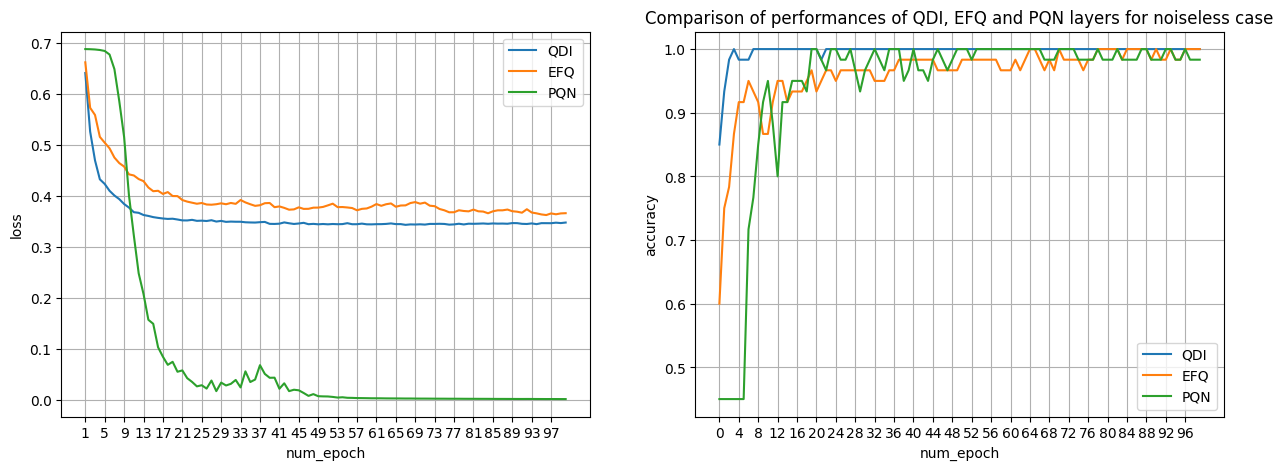

In [36]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
# ax.set_title('Comparison of QDI, EFQ and PQN performances for noiseless case')

ax[0].plot(np.arange(1, QDI_losses.shape[0] + 1), QDI_losses, label='QDI')
ax[0].plot(np.arange(1, EFQ_losses.shape[0] + 1), EFQ_losses, label='EFQ')
ax[0].plot(np.arange(1, PQN_losses.shape[0] + 1), PQN_losses, label='PQN')
ax[0].set_xticks(np.arange(1, QDI_losses.shape[0] + 1, 4))
ax[0].set_xlabel('num_epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[0].grid()

ax[1].plot(np.arange(QDI_accuracies.shape[0]), QDI_accuracies,
           label='QDI')
ax[1].plot(np.arange(EFQ_accuracies.shape[0]), EFQ_accuracies,
           label='EFQ')
ax[1].plot(np.arange(PQN_accuracies.shape[0]), PQN_accuracies,
           label='PQN')
ax[1].set_xticks(np.arange(0, PQN_accuracies.shape[0], 4))
ax[1].set_xlabel('num_epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
ax[1].grid()
plt.title('Comparison of performances of QDI, EFQ and PQN layers for noiseless case')
plt.show()

# Simulator with noise model specific to IBM Sherbrooke

In [ ]:
from qiskit_aer import noise
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_provider import IBMProvider
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

IBMProvider.save_account(token='d4d5a9ed2d4b576b105b9476fd9d61b464bae4f7fc0d1e543e698e576f59f537ffbf3f97a26668e5840fd0b53ab5f84541e03529de75bf2297236b8b79873dff',
                         overwrite=True)
service = QiskitRuntimeService()
backend = service.backend("ibm_sherbrooke")
noise_model = NoiseModel.from_backend(backend)
dev = qml.device('qiskit.aer', wires=range(num_qubits), noise_model=noise_model)

In [ ]:
@qml.qnode(dev, interface='torch')
def qdi_circuit(weights, input_array, wires=range(num_qubits)):
    for r in range(qdi_reps1):
        for i in range(len(wires)):
            qml.RX(weights[r][i], wires=wires[i])
        for j in range(len(wires)-1):
            qml.CNOT(wires=[wires[j], wires[j+1]])
        qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
        qml.Barrier()
    for d in range(qdi_depth):
        qml.AngleEmbedding(input_array, wires=range(num_qubits), rotation='Z')
        for r in range(qdi_reps2):
            for i in range(len(wires)):
                qml.RX(weights[qdi_reps1+d*r][i], wires=wires[i])
            for j in range(len(wires)-1):
                qml.CNOT(wires=[wires[j], wires[j+1]])
            qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
            qml.Barrier()
        qml.Barrier()
    return qml.expval(qml.PauliY(0))
@qml.qnode(dev, interface="torch")
def efq_circuit(weights, input_array):
    qml.layer(efq_subroutine, efq_depth, params = weights, input_array = input_array)
    return qml.expval(qml.PauliZ(0))
@qml.qnode(dev, interface='torch')
def pqn_circuit(weights, input_array):
    result = torch.zeros(pqn_c).to(device)
    for i in range(pqn_c):
        result[i] = qdi_circuit(weights[i], input_array[i*par_qubits:(i+1)*par_qubits], wires = range(i*par_qubits, (i+1)*par_qubits))
    return result

In [ ]:
class QDIHybridModel_nsy(nn.Module):
    def __init__(self):
        super(QDIHybridModel_nsy, self).__init__()
        self.classical_layer = nn.Linear(input_dim, num_qubits)
        self.q_params = nn.Parameter(torch.randn((qdi_reps1 + qdi_depth*qdi_reps2, num_qubits)))
    def forward(self, x):
        x = torch.relu(self.classical_layer(x))
        q_out = torch.zeros(x.size(0), device=device)
        for i in range(x.size(0)):
            q_out[i] = qdi_circuit(self.q_params, x[i])
        return torch.sigmoid(q_out)

In [ ]:
class EFQHybridModel_nsy(nn.Module):
    def __init__(self):
        super(EFQHybridModel_nsy, self).__init__()
        self.classical_layer = nn.Linear(input_dim, num_qubits)
        self.q_params = nn.Parameter(torch.randn((12*efq_depth*num_qubits, )))
    def forward(self, x):
        x = torch.relu(self.classical_layer(x))
        q_out = torch.zeros(x.size(0), device=device)
        for i in range(x.size(0)):
            q_out[i] = efq_circuit(self.q_params, x[i])
        return torch.sigmoid(q_out)

In [ ]:
class PQNHybridModel_nsy(nn.Module):
    def __init__(self):
        super(PQNHybridModel_nsy, self).__init__()
        self.classical_layer_1 = nn.Linear(input_dim, num_qubits)
        self.classical_layer_2 = nn.Linear(num_qubits//2, 1)
        self.q_params = nn.Parameter(torch.randn(pqn_c, qdi_reps1 + qdi_depth*qdi_reps2, num_qubits//pqn_c, ))
    def forward(self, x):
        x = torch.relu(self.classical_layer_1(x))
        q_out = torch.zeros((x.size(0), 2), device=device)
        for i in range(x.size(0)):
            q_out[i] = pqn_circuit(self.q_params, x[i])
        output = self.classical_layer_2(q_out)
        return torch.sigmoid(output).squeeze(1)

In [ ]:
criterion = nn.BCELoss()


In [ ]:
QDI_model_nsy = QDIHybridModel_nsy().to(device)
optimizer_for_nsy_qdi = optim.Adam(QDI_model_nsy.parameters(), lr=learning_rate)

In [ ]:
EFQ_model_nsy = EFQHybridModel_nsy().to(device)
optimizer_for_nsy_efq = optim.Adam(EFQ_model_nsy.parameters(), lr=learning_rate)

In [ ]:
PQN_model_nsy = PQNHybridModel_nsy().to(device)
optimizer_for_nsy_pqn = optim.Adam(PQN_model_nsy.parameters(), lr=learning_rate)

In [ ]:
QDI_losses_nsy, \
    QDI_accuracies_nsy = train(QDI_model_nsy, criterion=criterion,
                              optimizer=optimizer_for_nsy_qdi,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              num_epochs=epochs)

In [ ]:
EFQ_losses_nsy, \
    EFQ_accuracies_nsy = train(EFQ_model_nsy, criterion=criterion,
                              optimizer=optimizer_for_nsy_efq,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              num_epochs=epochs)

In [ ]:
PQN_losses_nsy, \
    PQN_accuracies_nsy = train(PQN_model_nsy, criterion=criterion,
                              optimizer=optimizer_for_nsy_pqn,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              num_epochs=epochs)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(np.arange(1, QDI_losses_nsy.shape[0] + 1), QDI_losses_nsy, label='QDI')
ax[0].plot(np.arange(1, EFQ_losses_nsy.shape[0] + 1), EFQ_losses_nsy, label='EFQ')
ax[0].plot(np.arange(1, PQN_losses_nsy.shape[0] + 1), PQN_losses_nsy, label='PQN')
ax[0].set_xticks(np.arange(1, QDI_losses_nsy.shape[0]+ 1, 4))
ax[0].set_xlabel('num_epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[0].grid()

ax[1].plot(np.arange(QDI_accuracies_nsy.shape[0]), QDI_accuracies_nsy,
           label='QDI')
ax[1].plot(np.arange(EFQ_accuracies_nsy.shape[0]), EFQ_accuracies_nsy,
           label='EFQ')
ax[1].plot(np.arange(PQN_accuracies_nsy.shape[0]), PQN_accuracies_nsy,
           label='PQN')
ax[1].set_xticks(np.arange(0, PQN_accuracies_nsy.shape[0], 4))
ax[1].set_xlabel('num_epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
ax[1].grid()
plt.title('Comparison of performances of QDI, EFQ and PQN layers for noisy case')
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 3, figsize = (15, 5))

ax[0, 0].plot(np.arange(1, QDI_losses.shape[0] + 1), QDI_losses, label='QDI, noiseless case')
ax[0, 0].plot(np.arange(1, QDI_losses_nsy.shape[0] + 1), QDI_losses_nsy, label='QDI, noisy case')
ax[0, 0].set_xticks(np.arange(1, QDI_losses_nsy.shape[0] + 1, 4))
ax[0, 0].set_xlabel('num_epoch')
ax[0, 0].set_ylabel('loss')
ax[0, 0].legend()
ax[0, 0].grid()

ax[0, 1].plot(np.arange(1, EFQ_losses.shape[0] + 1), EFQ_losses, label='EFQ, noiseless case')
ax[0, 1].plot(np.arange(1, EFQ_losses_nsy.shape[0] + 1), EFQ_losses_nsy, label='EFQ, noisy case')
ax[0, 1].set_xticks(np.arange(1, EFQ_losses_nsy.shape[0] + 1, 4))
ax[0, 1].set_xlabel('num_epoch')
ax[0, 1].set_ylabel('loss')
ax[0, 1].legend()
ax[0, 1].grid()

ax[0, 2].plot(np.arange(1, PQN_losses.shape[0] + 1), PQN_losses, label='PQN, noiseless case')
ax[0, 2].plot(np.arange(1, PQN_losses_nsy.shape[0] + 1), PQN_losses_nsy, label='PQN, noisy case')
ax[0, 2].set_xticks(np.arange(1, PQN_losses_nsy.shape[0]+ 1, 4))
ax[0, 2].set_xlabel('num_epoch')
ax[0, 2].set_ylabel('loss')
ax[0, 2].legend()
ax[0, 2].grid()

ax[1, 0].plot(np.arange(QDI_accuracies.shape[0]), QDI_accuracies, label='QDI, noiseless case')
ax[1, 0].plot(np.arange(QDI_accuracies_nsy.shape[0]), QDI_accuracies_nsy, label='QDI, noisy case')
ax[1, 0].set_xticks(np.arange(0, QDI_accuracies_nsy.shape[0], 4))
ax[1, 0].set_xlabel('num_epoch')
ax[1, 0].set_ylabel('accuracy')
ax[1, 0].legend()
ax[1, 0].grid()

ax[1, 1].plot(np.arange(EFQ_accuracies.shape[0]), EFQ_accuracies, label='EFQ, noiseless case')
ax[1, 1].plot(np.arange((EFQ_accuracies_nsy)), EFQ_accuracies_nsy, label='EFQ, noisy case')
ax[1, 1].set_xticks(np.arange(0, EFQ_accuracies_nsy.shape[0], 4))
ax[1, 1].set_xlabel('num_epoch')
ax[1, 1].set_ylabel('accuracy')
ax[1, 1].legend()
ax[1, 1].grid()

ax[1, 2].plot(np.arange(PQN_accuracies.shape[0]), PQN_accuracies, label='PQN, noiseless case')
ax[1, 2].plot(np.arange(PQN_accuracies_nsy.shape[0]), PQN_accuracies_nsy, label='PQN, noisy case')
ax[1, 2].set_xticks(np.arange(0, PQN_accuracies_nsy.shape[0], 4))
ax[1, 2].set_xlabel('num_epoch')
ax[1, 2].set_ylabel('accuracy')
ax[1, 2].legend()
ax[1, 2].grid()
plt.title("Comparison performances of layers for noiseless and noisy cases")

plt.show()

# Forward pass with the IBM Sherbrooke device

In [ ]:
dev = qml.device("qiskit.ibmq", wires=range(num_qubits), backend=backend)

In [ ]:
@qml.qnode(dev, interface='torch')
def qdi_circuit_for_ibmq(weights, input_array, wires=range(num_qubits)):
    for r in range(qdi_reps1):
        for i in range(len(wires)):
            qml.RX(weights[r][i], wires=wires[i])
        for j in range(len(wires)-1):
            qml.CNOT(wires=[wires[j], wires[j+1]])
        qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
        qml.Barrier()
    for d in range(qdi_depth):
        qml.AngleEmbedding(input_array, wires=range(num_qubits), rotation='Z')
        for r in range(qdi_reps2):
            for i in range(len(wires)):
                qml.RX(weights[qdi_reps1+d*r][i], wires=wires[i])
            for j in range(len(wires)-1):
                qml.CNOT(wires=[wires[j], wires[j+1]])
            qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
            qml.Barrier()
        qml.Barrier()
    return qml.expval(qml.PauliY(0))

In [ ]:
class QDIHybridModel_ibmq_unmitigated(nn.Module):
    def __init__(self):
        super(QDIHybridModel_ibmq_unmitigated, self).__init__()
        self.classical_layer = nn.Linear(input_dim, num_qubits)
        self.q_params = nn.Parameter(torch.randn((qdi_reps1 + qdi_depth*qdi_reps2, num_qubits)))
    def forward(self, x):
        x = torch.relu(self.classical_layer(x))
        q_out = torch.zeros(x.size(0), device=device)
        for i in range(x.size(0)):
            q_out[i] = qdi_circuit_for_ibmq(self.q_params, x[i])
        return torch.sigmoid(q_out)

In [ ]:
QDI_model_ibmq = QDIHybridModel_ibmq_unmitigated().to(device)

In [ ]:
QDI_model_ibmq.load_state_dict(QDI_model.state_dict())

In [ ]:
unmitigated_accuracy = 0

QDI_model_ibmq.eval()
for batch in test_dataloader:
    X = batch[0].to(device)
    y = batch[1].to(device)

    with torch.no_grad():
        preds = (QDI_model_ibmq(X)>0.5).float()
        unmitigated_accuracy += (preds == y).cpu().numpy().mean()

unmitigated_accuracy /= len(test_dataloader)
print(f"Unmitigated accuracy {unmitigated_accuracy:.3f}")

In [ ]:
from mitiq.zne.scaling import fold_global
from mitiq.zne.inference import RichardsonFactory

scale_factors = [1, 2, 3]
noise_scale_method = fold_global

mitigated_qdi_circuit = qml.transforms.mitigate_with_zne(
    qdi_circuit_for_ibmq,
    scale_factors,
    noise_scale_method,
    RichardsonFactory.extrapolate,
)

In [ ]:
class QDIHybridModel_ibmq_mitigated(nn.Module):
    def __init__(self):
        super(QDIHybridModel_ibmq_mitigated, self).__init__()
        self.classical_layer = nn.Linear(input_dim, num_qubits)
        self.q_params = nn.Parameter(torch.randn((qdi_reps1 + qdi_depth*qdi_reps2, num_qubits)))
    def forward(self, x):
        x = torch.relu(self.classical_layer(x))
        q_out = torch.zeros(x.size(0), device=device)
        for i in range(x.size(0)):
            q_out[i] = mitigated_qdi_circuit(self.q_params, x[i])
        return torch.sigmoid(q_out)

In [ ]:
QDI_model_ibmq = QDIHybridModel_ibmq_mitigated().to(device)

In [ ]:
QDI_model_ibmq.load_state_dict(QDI_model.state_dict())

In [ ]:
mitigated_accuracy = 0

QDI_model_ibmq.eval()
for batch in test_dataloader:
    X = batch[0].to(device)
    y = batch[1].to(device)

    with torch.no_grad():
        preds = (QDI_model_ibmq(X)>0.5).float()
        mitigated_accuracy += (preds == y).cpu().numpy().mean()

mitigated_accuracy /= len(test_dataloader)
print(f"Mitigated accuracy {mitigated_accuracy:.3f}")

In [ ]:
print(f"Unmitigated accuracy {unmitigated_accuracy:.3f}")
print(f"Mitigated accuracy {mitigated_accuracy:.3f}")